## Imports

In [1]:
import torch
from torch.utils.data import DataLoader

from src.utils_data import load_PeMS04_flow_data, preprocess_PeMS_data, createLoaders, TimeSeriesDataset
from src.utils_graph import compute_laplacian_with_self_loop
from src.models import TGCN, GRUModel, LSTMModel, train_model

import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Print Results

In [2]:
def result_prediction(predictions, actuals):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    y_pred = predictions[:]
    y_true = actuals[:]

    signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    if (mape > 1 or mape < 0):
        mape = "ERROR"
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
    maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100
    
    return [signe, mae, rmse, mape, smape, maape]

In [3]:
def highlight_rows(row, min_val, max_val):
    if row["MAAPE"] == min_val:
        color = "green"
    elif row["MAAPE"] == max_val:
        color = "red"
    else:
        color = ""
    return [f'background-color: {color}'] * len(row)

## Test Model

In [17]:
def test_model(best_model, test_loader):
    import numpy as np
    
    # Load the best model and evaluate on the test set
    best_model.double()
    best_model.eval()
    criterion = torch.nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = (inputs).to(device)
            targets = (targets).squeeze().to(device)
            outputs = best_model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    test_loss /= len(test_loader)
    # print(f"Test Loss: {test_loss:.4f}")
    
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return (predictions, actuals)

## Parameters

In [5]:
n_neighbors = 49
normalization = "center_and_reduce"

# Define the sliding window size and stride
_window_size = 6
horizon = 1
_stride = horizon
path_save_model = f"./{normalization}/nb_captor_{n_neighbors+1}/windows_{_window_size}_out_{horizon}"

## Preprocessing data

In [6]:
df_PeMS_old, df_distance  = load_PeMS04_flow_data()
df_PeMS, adjacency_matrix_PeMS, meanstd_dict = preprocess_PeMS_data(df_PeMS_old, df_distance, init_node=0, n_neighbors=n_neighbors, center_and_reduce=True)

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


In [7]:
import matplotlib.pyplot as plt
def plot_losses(losses, title, label_line):
    plt.figure(figsize=(25, 9))
    plt.title(title)
    plt.plot(losses, label=label_line)
    plt.legend(fontsize=12)
    plt.show()

In [8]:
import copy
def create_multiple_model_with_one_captor(model, nb_model, name_dict, data, _windows_size, _stride):
    dict_model = {}
    for i in range(nb_model):
        #print(f"{name_dict}{i}")
        train_loader, val_loader, test_loader = createLoaders(pd.DataFrame(data.iloc[:, i]), window_size=_windows_size, stride=_stride, target_size=horizon)
        dict_model[f"{name_dict}{i}"] = {
                                "model": copy.deepcopy(model),
                                "train_loader": train_loader,
                                "val_loader": val_loader,
                                "test_loader": test_loader
        }
    return dict_model

## TGCN

In [9]:
train_loader_TGCN, val_loader_TGCN, test_loader_TGCN = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
model_TGCN = TGCN(adjacency_matrix_PeMS, hidden_dim=32, output_size=len(df_PeMS.columns))

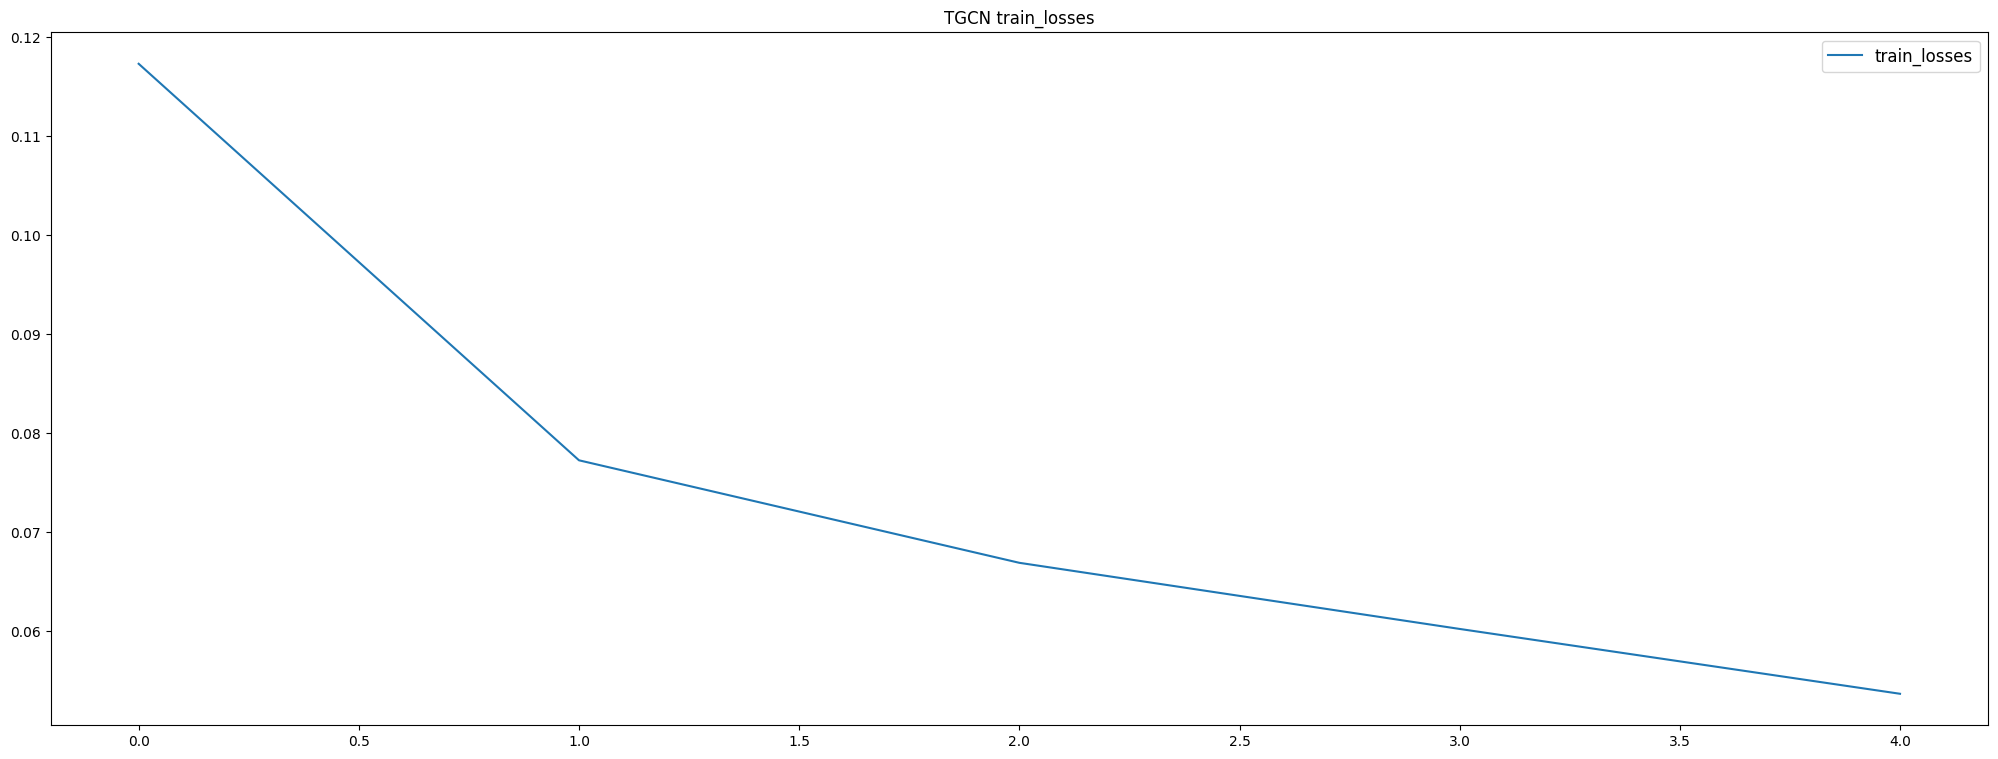

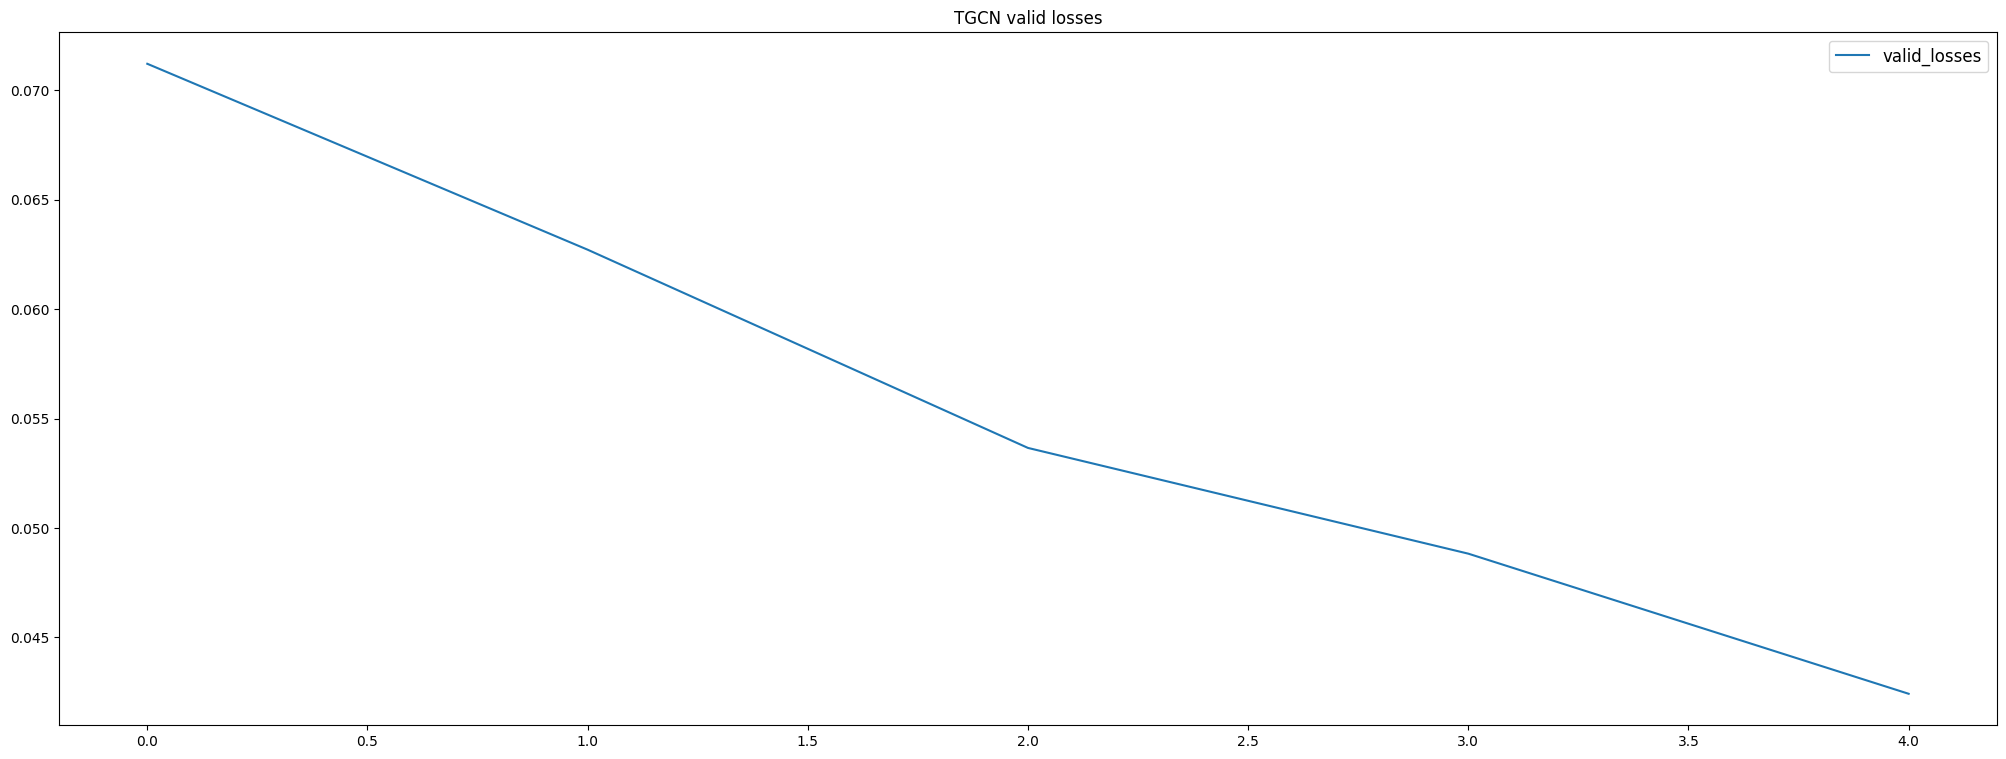

In [10]:
import matplotlib.pyplot as plt

num_epochs_TGCN = 5
model_path = f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl"
_ , valid_losses, train_losses = train_model(model_TGCN, train_loader_TGCN, val_loader_TGCN, model_path=model_path, num_epochs=num_epochs_TGCN, remove=False)

plot_losses(train_losses, "TGCN train_losses", "train_losses")
plot_losses(valid_losses, "TGCN valid losses", "valid_losses")


## Univariate 

In [11]:
# # LSTM
# num_epochs_LSTM_univariate = 3
# models_univaritate_LSTM = {}

# # GRU
# num_epochs_GRU_univaritate = 3
# models_univaritate_GRU = {}

In [12]:
# # LSTM
# models_univaritate_LSTM = create_multiple_model_with_one_captor(LSTMModel(1,32,1), n_neighbors+1, "LSTMModel", df_PeMS, _window_size, _stride)

# for i in range(n_neighbors+1):
#     _, valid_losses, train_losses = train_model(models_univaritate_LSTM[f"LSTMModel{i}"]["model"], 
#                 models_univaritate_LSTM[f"LSTMModel{i}"]["train_loader"], 
#                 models_univaritate_LSTM[f"LSTMModel{i}"]["val_loader"], 
#                 f"{path_save_model}/epoch_{num_epochs_LSTM_univariate}/univariate_LSTM_model_{i}.pkl", num_epochs=num_epochs_LSTM_univariate, remove=False)
#     plot_losses(train_losses, f"LSTM train_losses captor {df_PeMS.columns[i]}", "train_losses")
#     plot_losses(valid_losses, f"LSTM valid_losses captor {df_PeMS.columns[i]}", "valid_losses")


# # GRU
# models_univaritate_GRU = create_multiple_model_with_one_captor(GRUModel(1, 32, 1), n_neighbors+1, "GRUModel", df_PeMS, _window_size, _stride)

# for i in range(n_neighbors+1):
#     _, valid_losses, train_losses = train_model(models_univaritate_GRU[f"GRUModel{i}"]["model"], 
#             models_univaritate_GRU[f"GRUModel{i}"]["train_loader"], 
#             models_univaritate_GRU[f"GRUModel{i}"]["val_loader"], 
#             f"{path_save_model}/epoch_{num_epochs_GRU_univaritate}/univariate_GRU_model_{i}.pkl", num_epochs=num_epochs_GRU_univaritate, remove=False)
#     plot_losses(train_losses, f"GRU train_losses captor {df_PeMS.columns[i]}", "train_losses")
#     plot_losses(valid_losses, f"GRU valid_losses captor {df_PeMS.columns[i]}", "valid_losses")

## Results Multivariate vs Univariate (TGCN VS LSTM - GRU)

In [13]:
# import matplotlib.pyplot as plt
# ######################################################################
# # TGCN
# ######################################################################
# # load best model
# model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

# # Make predictions
# predictions_TGCN, actuals_TGCN = test_model(model_TGCN, test_loader_TGCN)


# for i in range(n_neighbors+1):
#     # Save result for each captor
#     temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#     temp.append(f"TGCN Model captor {df_PeMS.columns[i]}")
#     data = [temp]


# ######################################################################
# # LSTM
# ######################################################################
#     # load best model
#     models_univaritate_LSTM[f"LSTMModel{i}"]["model"].load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_univariate}/univariate_LSTM_model_{i}.pkl".format(input)))
    
#     # Make predictions
#     predictions_LSTM, actuals_LSTM = test_model(models_univaritate_LSTM[f"LSTMModel{i}"]["model"], 
#                                     models_univaritate_LSTM[f"LSTMModel{i}"]["test_loader"])

#     # Save result
#     temp = result_prediction(predictions_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#     temp.append(f"LSTM Model captor {df_PeMS.columns[i]}")
#     data.append(temp)


# ######################################################################
# # GRU
# ######################################################################
#     # Load best model
#     models_univaritate_GRU[f"GRUModel{i}"]["model"].load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_univaritate}/univariate_GRU_model_{i}.pkl".format(input)))
#     predictions_GRU, actuals_GRU = test_model(models_univaritate_GRU[f"GRUModel{i}"]["model"], 
#                                     models_univaritate_GRU[f"GRUModel{i}"]["test_loader"])

#     # Make predictions
#     temp = result_prediction(predictions_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"]
#                             , actuals_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#     # Save results
#     temp.append(f"GRU Model captor {df_PeMS.columns[i]}")
#     data.append(temp)


# ######################################################################
# # Dataframe
# ######################################################################
#     df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Captor"])

#     # Définir le mois comme index du DataFrame
#     df.set_index('Captor', inplace=True)

#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)
#     pd.set_option('display.width', None)

#     min_val = df['MAAPE'].min()
#     max_val = df['MAAPE'].max()

#     df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)
#     display(df)


# ######################################################################
# # Plots
# ######################################################################
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="orange", label="TGCN pred")
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="magenta", label="LSTM pred")
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="red", label="GRU pred" )
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()


## Multivariate

In [14]:
# LSTM
num_epochs_LSTM_multivariate = 5

# GRU
num_epochs_GRU_multivariate = 5

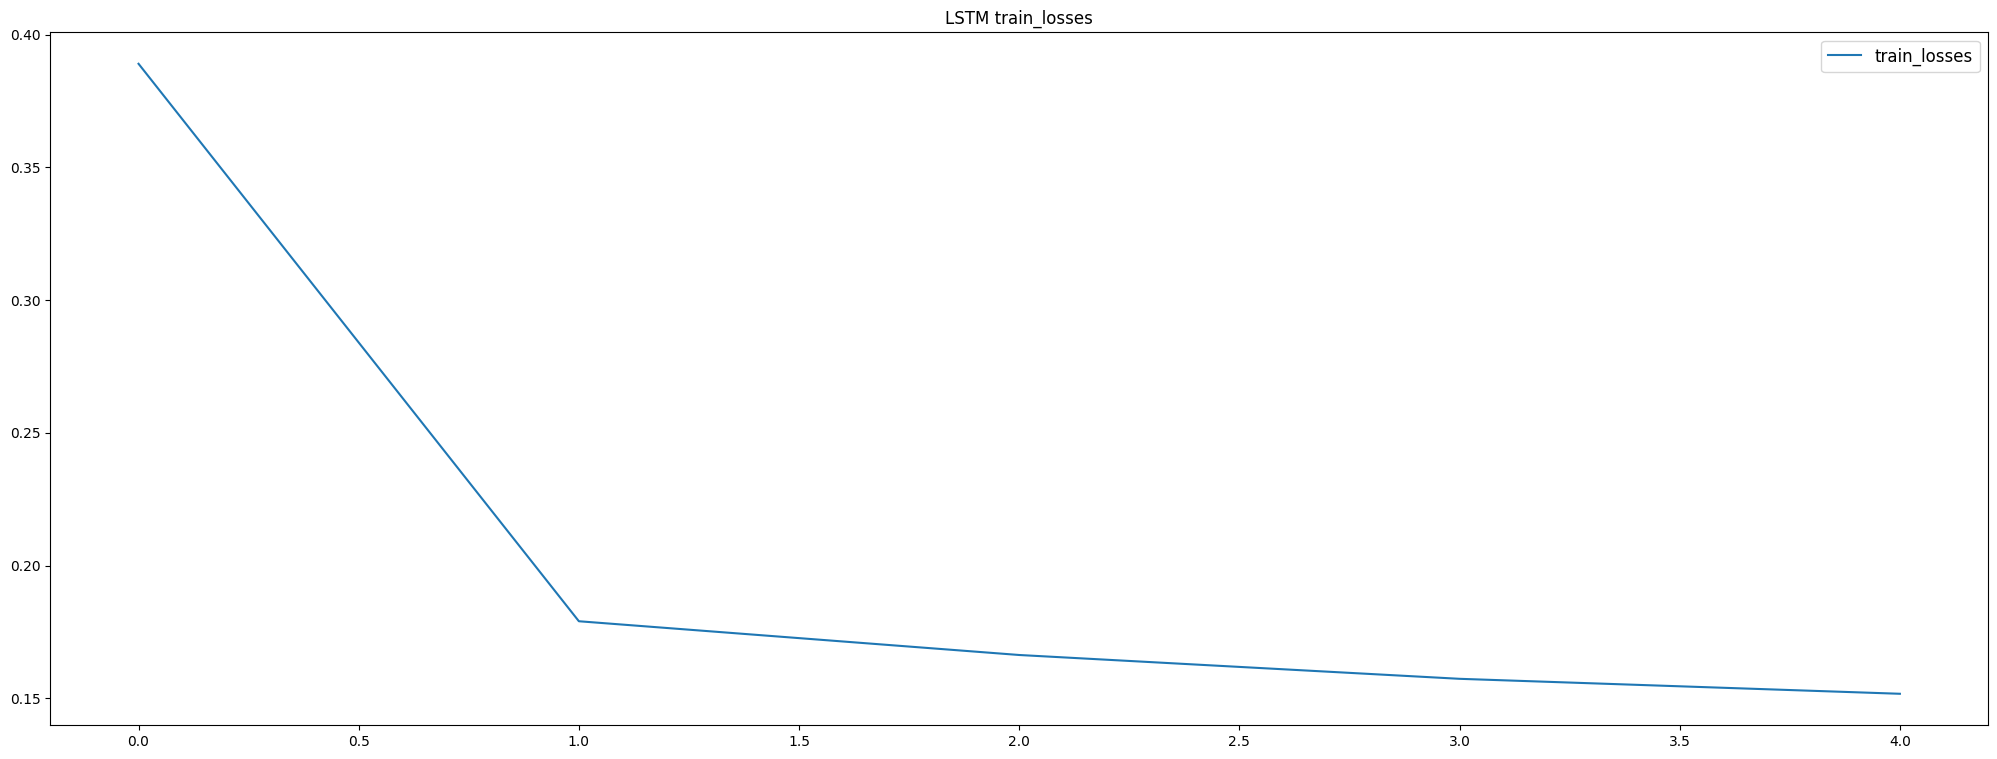

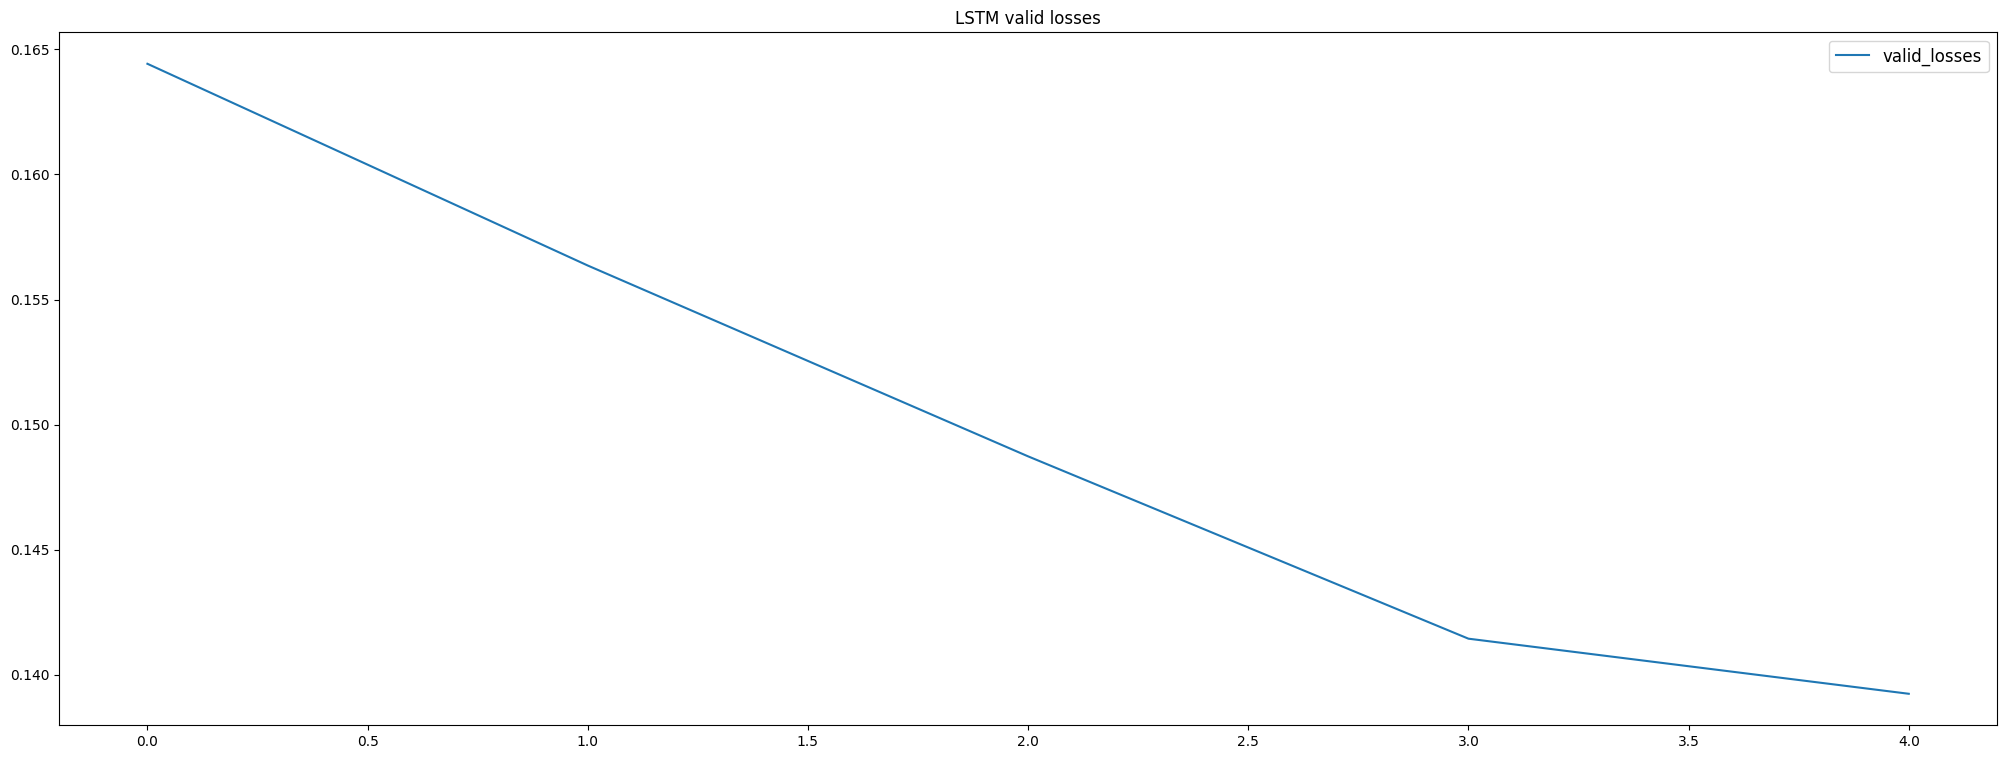

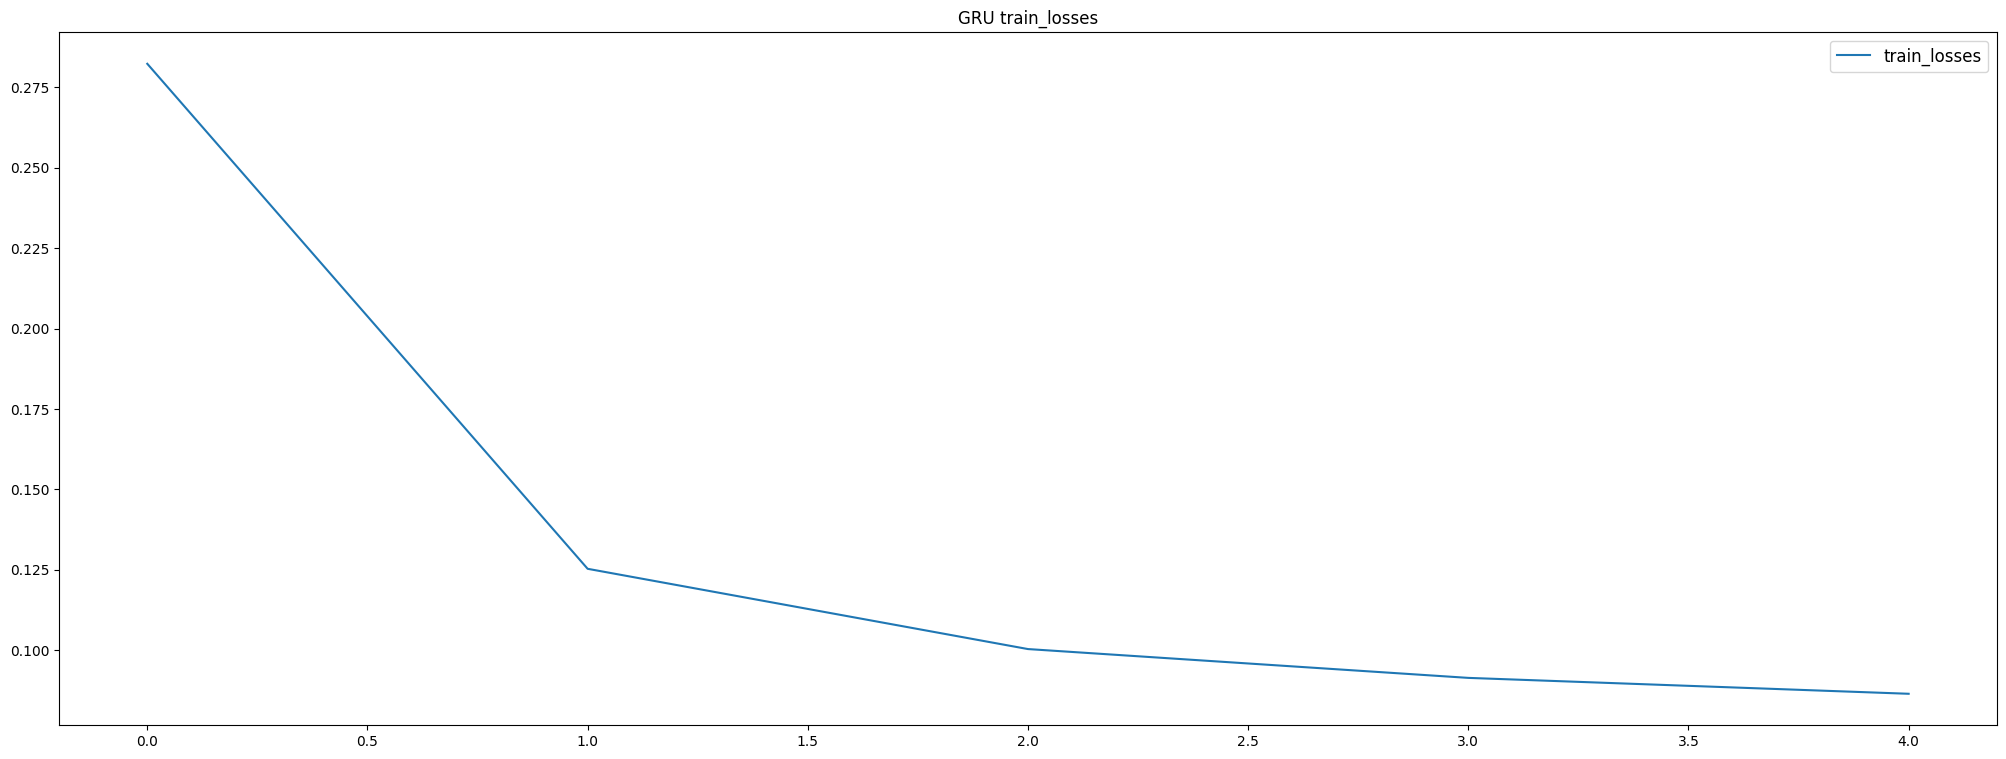

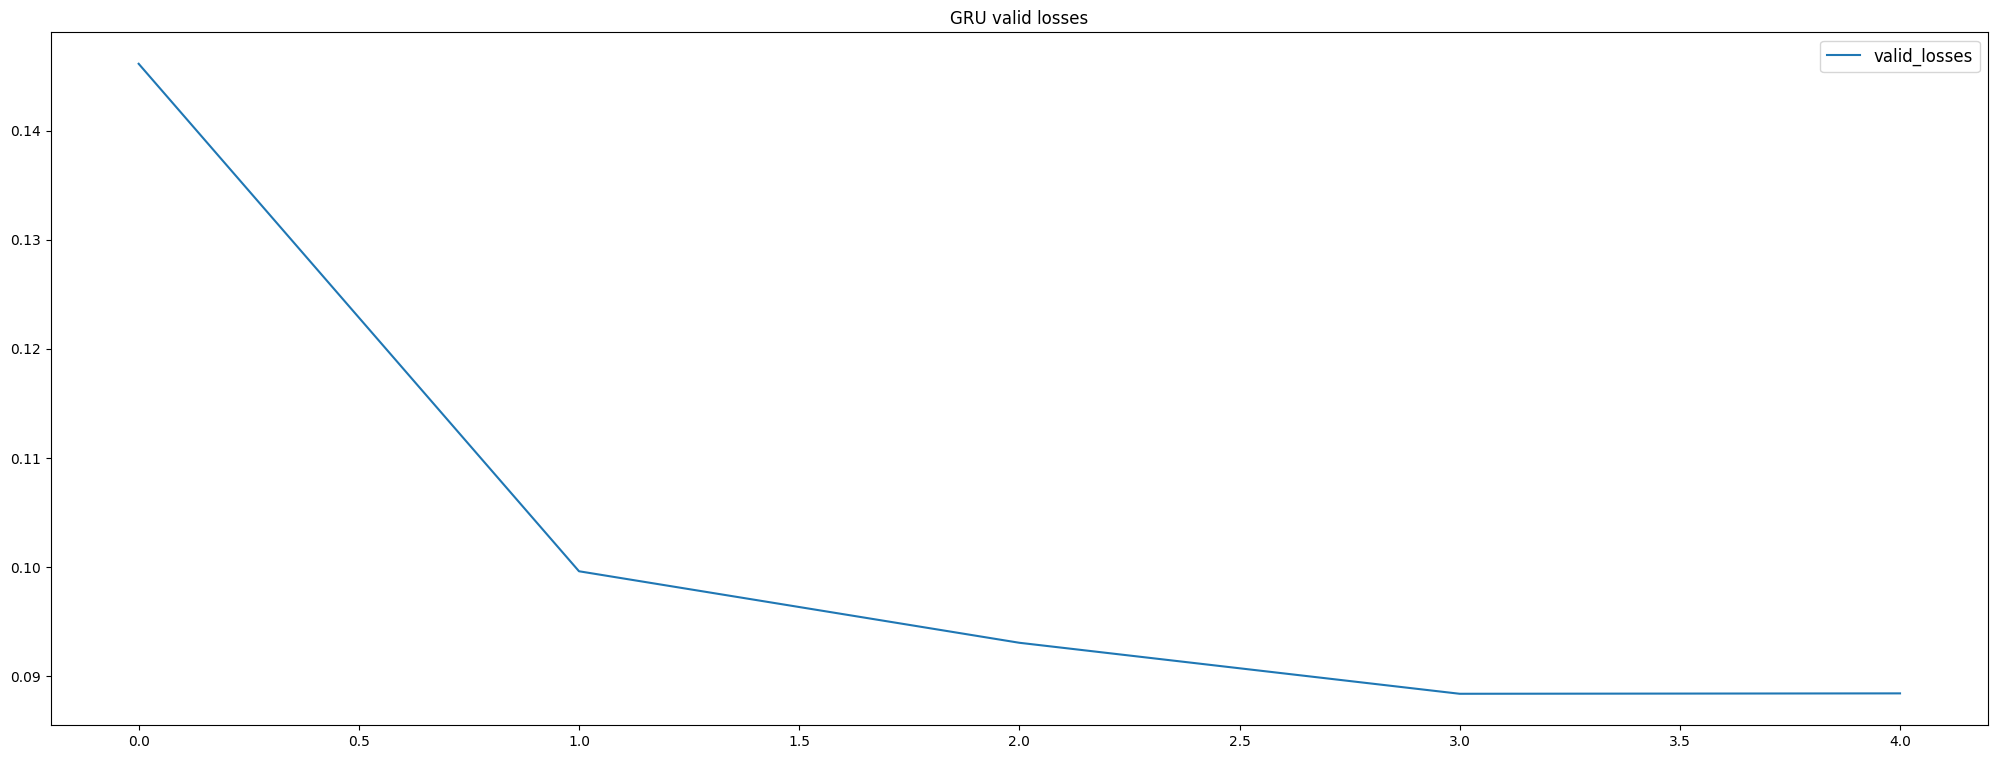

In [15]:
# LSTM
model_multivariate_LSTM = LSTMModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
train_loader_LSTM, val_loader_LSTM, test_loader_LSTM = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
_ , valid_losses, train_losses = train_model(model_multivariate_LSTM, train_loader_LSTM, val_loader_LSTM, 
                                            f"./{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl", 
                                            num_epochs=num_epochs_LSTM_multivariate, remove=False)
plot_losses(train_losses, "LSTM train_losses", "train_losses")
plot_losses(valid_losses, "LSTM valid losses", "valid_losses")

# GRU
model_multivariate_GRU = GRUModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
train_loader_GRU, val_loader_GRU, test_loader_GRU = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
_ , valid_losses, train_losses = train_model(model_multivariate_GRU, train_loader_GRU, val_loader_GRU, 
                                            f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl", 
                                            num_epochs=num_epochs_GRU_multivariate, remove=False)
plot_losses(train_losses, "GRU train_losses", "train_losses")
plot_losses(valid_losses, "GRU valid losses", "valid_losses")

## Results Multivariate vs Multivariate (TGCN VS LSTM - GRU)

RMSE                                                         \
           count       mean        std        min        25%        50%   
Model_Name                                                                
GRU Model   50.0  38.493475  29.166798  11.235456  26.994592  33.391395   
LSTM Model  50.0  52.200243  34.962014  11.537529  31.991547  41.796706   
TGCN Model  50.0  29.995257  15.621255   7.716241  21.688204  29.456536   

                                  SMAPE                                 \
                  75%         max count       mean       std       min   
Model_Name                                                               
GRU Model   40.974526  178.918690  50.0  14.687198  9.204802  6.659441   
LSTM Model  61.063240  175.546264  50.0  18.480934  9.582203  7.619829   
TGCN Model  33.971200  102.095695  50.0  13.033517  9.014085  4.649299   

                                                       MAAPE             \
                  25%        50%        75%        max count       mean   
Model_Name                                                                
GRU Model    9.591786  12.087609  14.098379  54.924748  50.0  14.666803   
LSTM Model  11.926926  14.582008  22.828715  54.471218  50.0  18.635410   
TGCN Model   8.175119  10.345815  14.744204  51.484460  50.0  12.427556   

                                                                            
                 std       min        25%        50%        75%        max  
Model_Name                                                                  
GRU Model   8.850330  6.742649   9.560092  12.548699  14.755908  59.737284  
LSTM Model  9.583115  7.538662  12.374532  15.127223  22.945161  61.674366  
TGCN Model  7.304242  4.558465   8.275861  10.449308  14.340705  44.628857

MAAPE                                                      
             count    mean       std    min     25%   50%     75%    max
Diff                                                                    
GRU vs LSTM   50.0 -3.9690  5.963826 -21.72 -6.8500 -2.32  0.0675   4.49
GRU vs TGCN   50.0  2.2390  6.655760 -12.35  0.5175  2.09  4.1100  36.53
LSTM vs GRU   50.0  3.9690  5.963826  -4.49 -0.0675  2.32  6.8500  21.72
LSTM vs TGCN  50.0  6.2078  8.205159  -9.53  1.6925  5.33  8.3475  38.46
TGCN vs GRU   50.0 -2.2390  6.655760 -36.53 -4.1100 -2.09 -0.5175  12.35
TGCN vs LSTM  50.0 -6.2078  8.205159 -38.46 -8.3475 -5.33 -1.6925   9.53

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

([<matplotlib.axis.YTick at 0x226987df550>,
 [Text(0, 0.0, '0'),
  Text(0, 4.0, '4'),
  Text(0, 8.0, '8'),
  Text(0, 12.0, '12'),
  Text(0, 16.0, '16'),
  Text(0, 20.0, '20'),
  Text(0, 24.0, '24'),
  Text(0, 28.0, '28'),
  Text(0, 32.0, '32'),
  Text(0, 36.0, '36'),
  Text(0, 40.0, '40'),
  Text(0, 44.0, '44'),
  Text(0, 48.0, '48'),
  Text(0, 52.0, '52'),
  Text(0, 56.0, '56'),
  Text(0, 60.0, '60')])

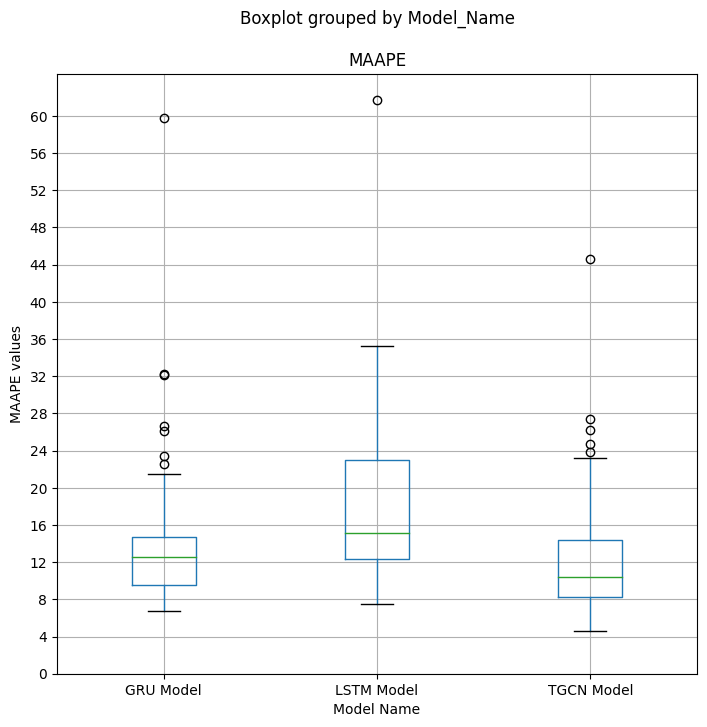

In [18]:
import matplotlib.pyplot as plt

final_resultats = []
diff_resultats = []

######################################################################
# TGCN
######################################################################
# load best model
model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

# Make predictions
predictions_TGCN, actuals_TGCN =  test_model(model_TGCN, test_loader_TGCN)


######################################################################
# LSTM
######################################################################
# load best model
model_multivariate_LSTM.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl".format(input)))
    
# Make predictions
predictions_LSTM, actuals_LSTM = test_model(model_multivariate_LSTM, 
                                test_loader_LSTM)


######################################################################
# GRU
######################################################################
# Load best model
model_multivariate_GRU.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl".format(input)))

# Make predictions
predictions_GRU, actuals_GRU = test_model(model_multivariate_GRU, 
                                test_loader_GRU)

for i in range(n_neighbors+1):

######################################################################
# TGCN
######################################################################
    # Save result for each captor
    temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                            actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
    temp.append("TGCN Model")
    temp.append(f"captor {df_PeMS.columns[i]}")
    data = [temp]
    final_resultats.append(temp)

######################################################################
# LSTM
######################################################################
    # Save result
    temp = result_prediction(predictions_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                            actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

    temp.append("LSTM Model")
    temp.append(f"captor {df_PeMS.columns[i]}")
    data.append(temp)
    final_resultats.append(temp)


######################################################################
# GRU
######################################################################
    # Save results
    temp = result_prediction(predictions_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                            actuals_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
    temp.append("GRU Model")
    temp.append(f"captor {df_PeMS.columns[i]}")
    data.append(temp)
    final_resultats.append(temp)


######################################################################
# Dataframe
######################################################################
    df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])

    df.set_index(["Captor", 'Model_Name'], inplace=True)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)

    min_val = df['MAAPE'].min()
    max_val = df['MAAPE'].max()

    df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)

#######################################################################
# Plots
#######################################################################
final_resultats = pd.DataFrame(final_resultats, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])
final_resultats.set_index(["Captor", 'Model_Name'], inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())
final_resultats.to_pickle(f"{path_save_model}/final_resultats.pkl")

stats = {
    "TGCN Model" : {"nb_win" : 0},
    "LSTM Model" : {"nb_win" : 0},
    "GRU Model" :  {"nb_win" : 0}
}

for i in final_resultats.index.get_level_values("Captor").unique():
    stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] = stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] + 1
    diff_resultats.append(["TGCN vs LSTM", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
    diff_resultats.append(["TGCN vs GRU", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
    diff_resultats.append(["LSTM vs TGCN", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
    diff_resultats.append(["LSTM vs GRU", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
    diff_resultats.append(["GRU vs TGCN", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
    diff_resultats.append(["GRU vs LSTM", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
diff_resultats = pd.DataFrame(diff_resultats, columns=["Diff", "MAAPE"])
diff_resultats.set_index(["Diff"], inplace=True)
display(diff_resultats.groupby("Diff").describe())
diff_resultats.groupby("Diff").describe().to_pickle(f"{path_save_model}/diff_results.pkl")

import numpy as np

bar_plot_results = final_resultats.reset_index()
display(bar_plot_results.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
plt.yticks(np.arange(0, bar_plot_results["MAAPE"].max(), 4))

RMSE                                                         \
           count       mean        std        min        25%        50%   
Model_Name                                                                
GRU Model   50.0  45.673464  28.371819  12.410549  30.825883  40.172821   
LSTM Model  50.0  55.179475  31.997855  13.911732  36.526861  50.190788   
TGCN Model  50.0  31.653979  17.019498   8.756533  21.465146  30.778255   

                                  SMAPE                                 \
                  75%         max count       mean       std       min   
Model_Name                                                               
GRU Model   52.612122  172.164279  50.0  17.122097  9.106125  7.589505   
LSTM Model  59.245636  174.317265  50.0  20.854335  8.511466  9.838745   
TGCN Model  35.031877  113.448964  50.0  14.015943  9.714138  4.785973   

                                                       MAAPE             \
                  25%        50%        75%        max count       mean   
Model_Name                                                                
GRU Model   12.183776  14.647070  16.858418  53.695450  50.0  16.709954   
LSTM Model  15.880039  18.330107  24.177030  48.452122  50.0  21.001537   
TGCN Model   8.546417  11.159721  15.390400  54.063035  50.0  13.226627   

                                                                             
                 std        min        25%        50%        75%        max  
Model_Name                                                                   
GRU Model   8.555828   7.734132  12.288740  14.484317  17.575645  57.527125  
LSTM Model  7.962281  10.270490  16.386050  19.062587  24.207096  51.855999  
TGCN Model  7.630106   4.719194   8.496746  10.968252  15.024414  45.838673

MAAPE                                                         
             count    mean       std    min      25%    50%      75%    max
Diff                                                                       
GRU vs LSTM   50.0 -4.2916  4.313663 -17.09  -6.3800 -3.695  -1.3750   5.67
GRU vs TGCN   50.0  3.4836  6.756398 -12.97   0.5875  3.170   5.5875  34.14
LSTM vs GRU   50.0  4.2916  4.313663  -5.67   1.3750  3.695   6.3800  17.09
LSTM vs TGCN  50.0  7.7754  6.381423  -5.28   3.7850  6.330  10.2075  28.47
TGCN vs GRU   50.0 -3.4836  6.756398 -34.14  -5.5875 -3.170  -0.5875  12.97
TGCN vs LSTM  50.0 -7.7754  6.381423 -28.47 -10.2075 -6.330  -3.7850   5.28

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

([<matplotlib.axis.YTick at 0x296eb9aa200>,
 [Text(0, 0.0, '0'),
  Text(0, 4.0, '4'),
  Text(0, 8.0, '8'),
  Text(0, 12.0, '12'),
  Text(0, 16.0, '16'),
  Text(0, 20.0, '20'),
  Text(0, 24.0, '24'),
  Text(0, 28.0, '28'),
  Text(0, 32.0, '32'),
  Text(0, 36.0, '36'),
  Text(0, 40.0, '40'),
  Text(0, 44.0, '44'),
  Text(0, 48.0, '48'),
  Text(0, 52.0, '52'),
  Text(0, 56.0, '56')])

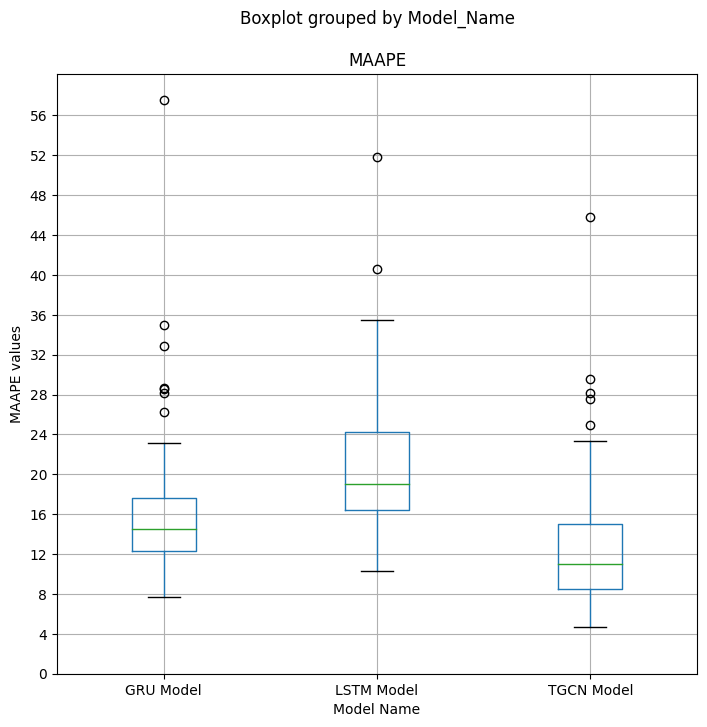

In [ ]:
final_resultats = pd.read_pickle(f"{path_save_model}/final_resultats.pkl")
display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())
diff_results = pd.read_pickle(f"{path_save_model}/diff_results.pkl")
display(diff_results)

bar_plot_results = final_resultats.reset_index()
display(bar_plot_results.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
plt.yticks(np.arange(0, bar_plot_results["MAAPE"].max(), 4))

## Multi_Experiments

In [ ]:
# import matplotlib.pyplot as plt

# # Define the sliding window size and stride
# _window_size = 6
# horizon = 6
# _stride = horizon

# for i in range(30, 50, 10):
#     n_neighbors = i
#     path_save_model = f"./{normalization}/nb_captor_{n_neighbors+1}/windows_{_window_size}_out_{horizon}"
#     df_PeMS, adjacency_matrix_PeMS, meanstd_dict = preprocess_PeMS_data(df_PeMS_old, df_distance, init_node=0, n_neighbors=n_neighbors, center_and_reduce=True)
    
#     # TGCN
#     train_loader_TGCN, val_loader_TGCN, test_loader_TGCN = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
#     model_TGCN = TGCN(adjacency_matrix_PeMS, hidden_dim=32, output_size=len(df_PeMS.columns))

#     model_path = f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl"
#     _ , _, _ = train_model(model_TGCN, train_loader_TGCN, val_loader_TGCN, model_path=model_path, num_epochs=num_epochs_TGCN, remove=False)


#     # LSTM
#     model_multivariate_LSTM = LSTMModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
#     train_loader_LSTM, val_loader_LSTM, test_loader_LSTM = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
#     _ , _, _ = train_model(model_multivariate_LSTM, train_loader_LSTM, val_loader_LSTM, 
#                                                 f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl", 
#                                                 num_epochs=num_epochs_LSTM_multivariate, remove=False)

#     # GRU
#     model_multivariate_GRU = GRUModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
#     train_loader_GRU, val_loader_GRU, test_loader_GRU = createLoaders(df_PeMS, window_size=_window_size, stride=_stride, target_size=horizon)
#     _ , _, _ = train_model(model_multivariate_GRU, train_loader_GRU, val_loader_GRU, 
#                                                 f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl", 
#                                                 num_epochs=num_epochs_GRU_multivariate, remove=False)


#     final_resultats = []
#     diff_resultats = []

#     ######################################################################
#     # TGCN
#     ######################################################################
#     # load best model
#     model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

#     # Make predictions
#     predictions_TGCN, actuals_TGCN =  test_model(model_TGCN, test_loader_TGCN)


#     ######################################################################
#     # LSTM
#     ######################################################################
#     # load best model
#     model_multivariate_LSTM.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl".format(input)))
        
#     # Make predictions
#     predictions_LSTM, actuals_LSTM = test_model(model_multivariate_LSTM, 
#                                     test_loader_LSTM)


#     ######################################################################
#     # GRU
#     ######################################################################
#     # Load best model
#     model_multivariate_GRU.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl".format(input)))

#     # Make predictions
#     predictions_GRU, actuals_GRU = test_model(model_multivariate_GRU, 
#                                     test_loader_GRU)

#     for i in range(n_neighbors+1):

#     ######################################################################
#     # TGCN
#     ######################################################################
#         # Save result for each captor
#         temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                                 actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#         temp.append("TGCN Model")
#         temp.append(f"captor {df_PeMS.columns[i]}")
#         data = [temp]
#         final_resultats.append(temp)

#     ######################################################################
#     # LSTM
#     ######################################################################
#         # Save result
#         temp = result_prediction(predictions_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                                 actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#         temp.append("LSTM Model")
#         temp.append(f"captor {df_PeMS.columns[i]}")
#         data.append(temp)
#         final_resultats.append(temp)


#     ######################################################################
#     # GRU
#     ######################################################################
#         # Save results
#         temp = result_prediction(predictions_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                                 actuals_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#         temp.append("GRU Model")
#         temp.append(f"captor {df_PeMS.columns[i]}")
#         data.append(temp)
#         final_resultats.append(temp)


#     ######################################################################
#     # Dataframe
#     ######################################################################
#         df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])

#         df.set_index(["Captor", 'Model_Name'], inplace=True)

#         pd.set_option('display.max_columns', None)
#         pd.set_option('display.max_rows', None)
#         pd.set_option('display.width', None)

#         min_val = df['MAAPE'].min()
#         max_val = df['MAAPE'].max()

#         df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)

#     #######################################################################
#     # Plots
#     #######################################################################
#     final_resultats = pd.DataFrame(final_resultats, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])
#     final_resultats.set_index(["Captor", 'Model_Name'], inplace=True)
#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)
#     pd.set_option('display.width', None)
#     display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())
#     final_resultats.to_pickle(f"{path_save_model}/final_resultats.pkl")

#     stats = {
#         "TGCN Model" : {"nb_win" : 0},
#         "LSTM Model" : {"nb_win" : 0},
#         "GRU Model" :  {"nb_win" : 0}
#     }

#     for i in final_resultats.index.get_level_values("Captor").unique():
#         stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] = stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] + 1
#         diff_resultats.append(["TGCN vs LSTM", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
#         diff_resultats.append(["TGCN vs GRU", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
#         diff_resultats.append(["LSTM vs TGCN", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
#         diff_resultats.append(["LSTM vs GRU", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
#         diff_resultats.append(["GRU vs TGCN", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
#         diff_resultats.append(["GRU vs LSTM", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
#     diff_resultats = pd.DataFrame(diff_resultats, columns=["Diff", "MAAPE"])
#     diff_resultats.set_index(["Diff"], inplace=True)
#     display(diff_resultats.groupby("Diff").describe())
#     diff_resultats.groupby("Diff").describe().to_pickle(f"{path_save_model}/diff_results.pkl")

#     import numpy as np

#     bar_plot_results = final_resultats.reset_index()
#     display(bar_plot_results.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
#     plt.yticks(np.arange(0, bar_plot_results["MAAPE"].max(), 4))